# Jake grating analysis

In [1]:
# Import the rest
from __future__ import print_function
from __future__ import division

import sys
sys.path.insert(0, '/home/dbutts/Code')
sys.path.insert(0, '/home/dbutts/Marmo/V1FreeViewingCode/Analysis/notebooks/')
import Utils as U
import gratings as gt
import NDN3.NDNutils as NDNutils
which_gpu = NDNutils.assign_gpu()
#NDNutils.setup_no_gpu()


import os
import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
from copy import deepcopy

import time
import random
import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU
#import NDN3.Utils.NDNplot as NDNplot
output_dir = '/home/dbutts/Code/PyOutput/output_dir' + str(which_gpu)
print(output_dir)

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 0, 1: 10772}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!
/home/dbutts/Code/PyOutput/output_dir0


In [2]:
dirname = '/home/dbutts/Marmo/GratingProject/'
os.chdir(dirname) 
from scipy.io import loadmat

opts = loadmat('testdata.mat')

stim = opts['stim']
sacon = opts['sacon'].T
sacoff = opts['sacoff'].T
basis = opts['basis']
Robs = opts['Robs']
RobsAll = deepcopy(Robs)
sacbc = opts['sacbc']
valid = opts['valid']
eyepos = opts['eyepos']
# gotta clean up for the borked way loadmat works
opts['NX'] = opts['NX'][0][0]
opts['NY'] = opts['NY'][0][0]
opts['Ui'] = opts['Ui'][0]
opts['Xi'] = opts['Xi'][0]
opts['Ti'] = opts['Ti'][0]
# opts['num_repeats'] = opts['num_repeats'][0][0]

Ui = opts['Ui']
Xi = opts['Xi']
Ti = opts['Ti']

Text(0, 0.5, 'd.v.a')

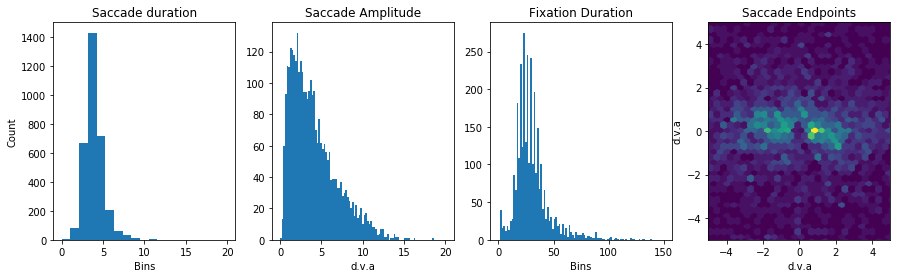

In [3]:
# plot raw data
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]

# saccade endpoints
dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]

# saccade Amplitude
sacAmp = np.hypot(dx, dy)
sacAmp[np.isnan(sacAmp)] = 0

plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
f = plt.hist(ixoff-ixon, bins=np.linspace(0, 20,20))
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Saccade duration')

plt.subplot(1,4,2)
f = plt.hist(sacAmp, bins=np.linspace(0, 20,100))
plt.xlabel('d.v.a')
plt.title('Saccade Amplitude')

plt.subplot(1,4,3)
f = plt.hist(ixon[1:]-ixoff[:-1], bins=np.linspace(0, 150,100))
plt.xlabel('Bins')
plt.title('Fixation Duration')

plt.subplot(1,4,4)
f = plt.hexbin(dx, dy,gridsize=100)
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Saccade Endpoints')
plt.xlabel('d.v.a')
plt.ylabel('d.v.a')

/home/dbutts/Marmo/V1FreeViewingCode/Analysis/notebooks/gratings.py:830: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(b+1e-20))/np.log(pows)


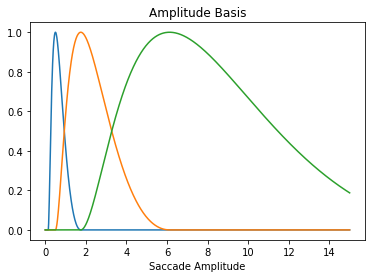

In [4]:
# if you want to do the saccade amplitude basis
# project saccade size on a tent basis
nSacBasis = 3
bax = np.linspace(0,15,1000)
# sB = gt.tent_basis_log(bax,nSacBasis,0.5,2.5)
sB = gt.raised_cosine(bax,nSacBasis,0.5,3.5)
plt.plot(bax, sB)
plt.xlabel("Saccade Amplitude")
plt.title('Amplitude Basis')
sacOnAmp = deepcopy(sacon)
sacOnAmp[ixon,0] = sacAmp
sacOnAmp = gt.raised_cosine(sacOnAmp.flatten(),nSacBasis,0.5,3.5)

sacOffAmp = deepcopy(sacoff)
sacOffAmp[ixoff,0] = sacAmp
sacOffAmp = gt.raised_cosine(sacOffAmp.flatten(), nSacBasis, 0.5, 3.5)

back_shiftson = 40
back_shiftsoff = 2
sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)
sacOffAmpshift = NDNutils.shift_mat_zpad(sacOffAmp,-back_shiftsoff,dim=0)

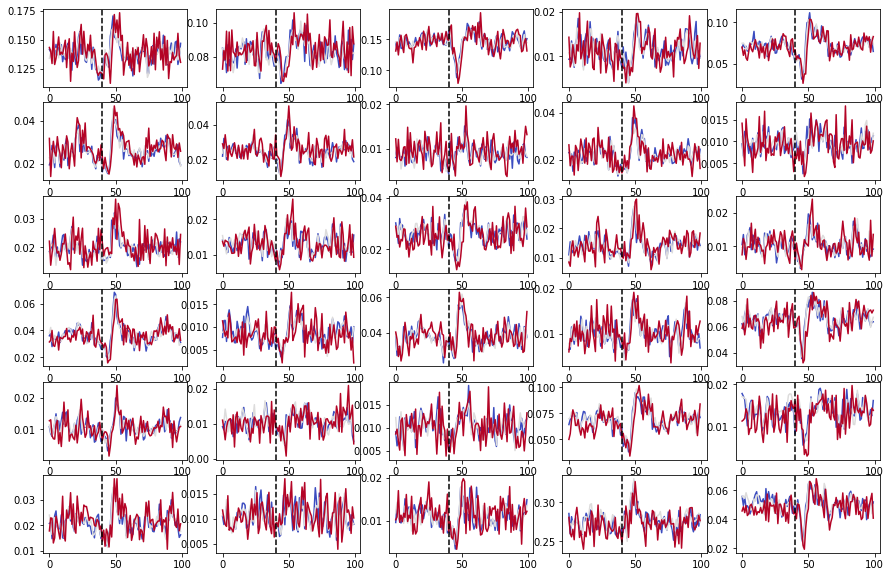

In [5]:
# plot the saccade-triggered firing rate 
nlags = 100

# use sacAmpshift to see if there's modulation / size selectivity
Xsacon = NDNutils.create_time_embedding( sacOnAmpshift, [nlags, 1, nSacBasis], tent_spacing=1)

NC = Robs.shape[1]
cm = plt.cm

sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))

cm = plt.cm.coolwarm(np.linspace(0, 1, nSacBasis))

for cc in range(NC):
    
    rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon
    
    sacta = np.sum(rmult[Ui,:], axis=0)/np.sum(Xsacon[Ui,:], axis=0)
    sacta = np.reshape(sacta, (nSacBasis, nlags)).T
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(sacta[:,i], color=cm[i])

    plt.axvline(x=back_shiftson,color='k',linestyle='--')

## Use size tuning to capture duration effects

In [6]:
# optimizer parameters
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 10000

In [7]:
# fit stimulus model and remove bad units
num_tkerns = 3
num_lags = 15
seed = 5
NX = opts['NX']
NY = opts['NY']
NC = RobsAll.shape[1]

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'orth':[1e-2],'d2t': [1e-5], 'd2x': [None,1e-5], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist='poisson')

_ = glm.train(input_data=[stim], output_data=RobsAll, train_indxs=Ui, test_indxs=Xi,
    learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=RobsAll, data_indxs=Xi, nulladjusted=True)

cids = LLx0>0.01
print("%d/%d units better than null model" %(np.sum(cids), len(LLx0)))
Robs = deepcopy(RobsAll[:,cids])

Input dimensions: [1, 8, 7]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E30/I0] 
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.180878
  Number of iterations: 156
  Number of functions evaluations: 173
Done Training Initial Model
17/30 units better than null model


In [8]:
## Fit GLM stimulus model (good units only)
NT,NC=Robs.shape
print("%d Time points, %d Neurons" %(NT, NC))

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'orth':[1e-3],'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist='poisson')

_ = glm.train(input_data=[stim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=Robs, data_indxs=Xi, nulladjusted=True)

112800 Time points, 17 Neurons
Input dimensions: [1, 8, 7]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E17/I0] 
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.740822
  Number of iterations: 103
  Number of functions evaluations: 114
Done Training Initial Model


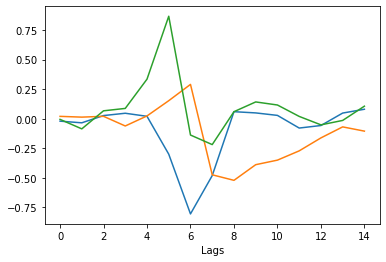

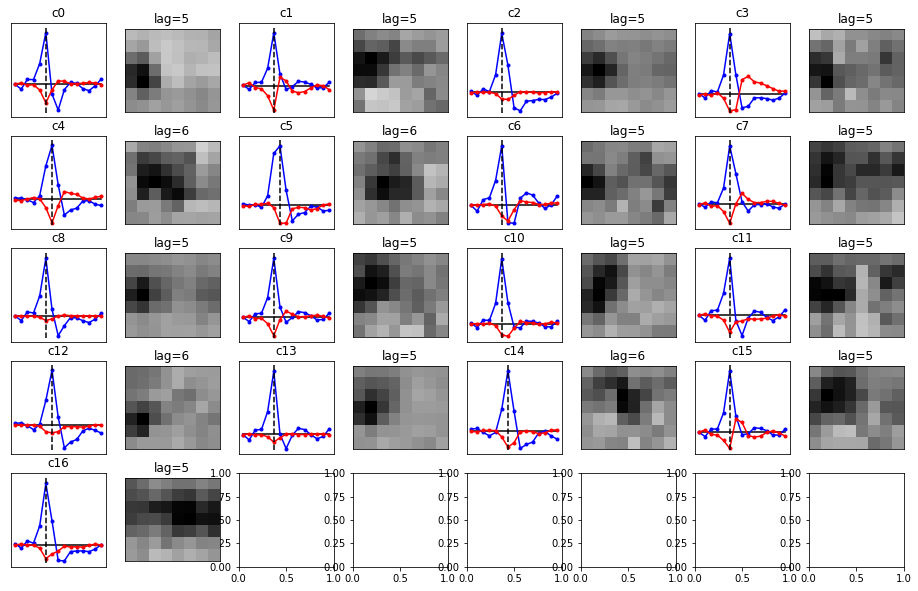

In [9]:
plt.figure()
plt.plot(glm.networks[0].layers[0].weights)
plt.xlabel("Lags")

DU.plot_3dfilters(glm)

### Unshared additive model

In [10]:
# build saccade inputs
num_onlags = 110
back_shiftson = 50 # will be amount of pre_saccadic (preceding saccade)

# choose first element of tspacing greater than zero (made it 5) to make it go to zero at front edge
tspacing = list(np.concatenate([np.arange(5,30,5), np.arange(30,50,3), 
                                np.arange(50,60,2), np.arange(60,num_onlags,5)]))

saconshift = NDNutils.shift_mat_zpad(sacon,-back_shiftson,dim=0)

sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)

print("%d nans found" %(np.sum(np.isnan(sacOnAmpshift))))

0 nans found


In [16]:
# saccade modulation model is NOT shared
num_sactkerns = 6

stim_par = deepcopy(glm_par)  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[0.1], 'd2x':[None, None]})


comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn1 = NDN.NDN([stim_par, sac_on_par, comb_par], noise_dist='poisson')
ndn1.networks[1].layers[0].init_temporal_basis( xs=tspacing )

# stimulus is the same
ndn1.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ndn1.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
#ndn1.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add network has 0 bias and weights 1
ndn1.networks[2].layers[0].weights[:,:] = 1.0

# Train
v2f0 = ndn1.fit_variables(layers_to_skip=[[0,1], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn1.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

# Refit all variables
v2f0 = ndn1.fit_variables(layers_to_skip=[[0], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn1.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")
LLx1 = Mndn1.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx1))

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E6/I0] N
1: normal (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 106 to 110.
  Temporal layer: updating number of weights in temporal layer from 110 to 27.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.159981
  Number of iterations: 108
  Number of functions evaluations: 128
Done training additive saccade model
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.151985
  Number of iterations: 40
  Number of functions evaluations: 74
Done training additive saccade model
0.320541 0.3305988


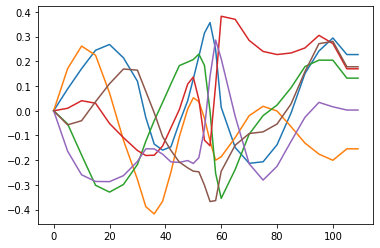

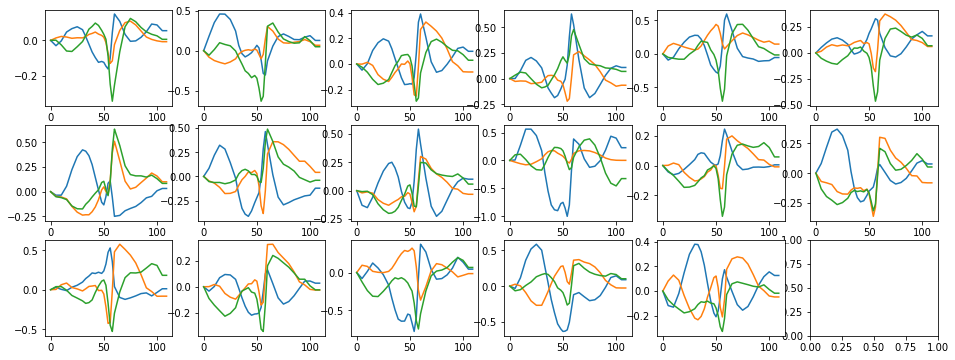

In [15]:
plt.plot(ndn1.networks[1].layers[0].filter_basis@ndn1.networks[1].layers[0].weights)
plt.show()
ks = DU.compute_spatiotemporal_filters(ndn1, ffnet=1)
DU.subplot_setup(3,6)
for nn in range(NC):
    plt.subplot(3,6,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()

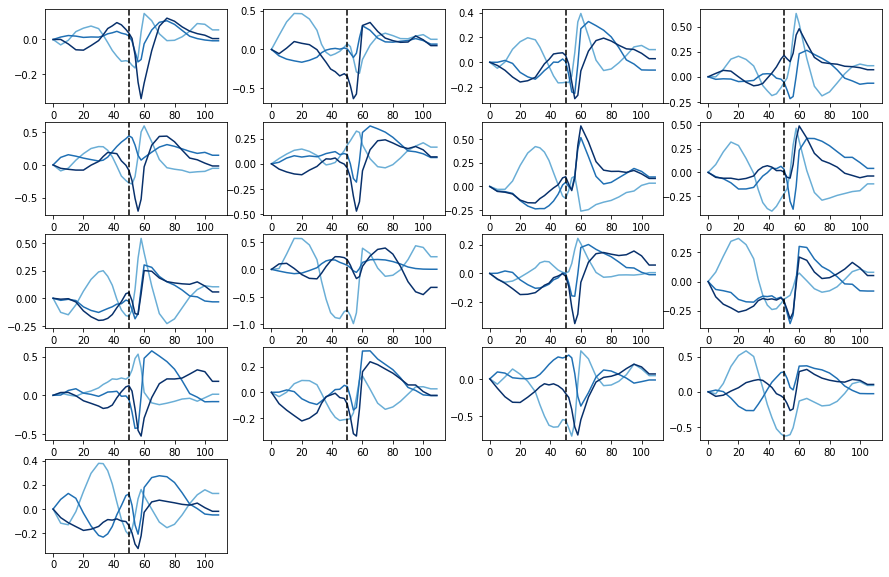

In [12]:
# plot kernels
ndn_mod = ndn1.copy_model()
ffnet = 1
# filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet) # not working??

ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)

w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights

w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')

## Multiplicative play

In [13]:
# ADDITIVE PARAMETERS
num_onlags = 110
back_shiftson = 50 # will be amount of pre_saccadic (preceding saccade)

# choose first element of tspacing greater than zero (made it 5) to make it go to zero at front edge
tspacing = list(np.concatenate([np.arange(5,30,5), np.arange(30,50,3), np.arange(50,60,2), 
                                np.arange(60,num_onlags,5)]))
#saconshift = NDNutils.shift_mat_zpad(sacon,-back_shiftson,dim=0)
sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)

# MULTIPLICATIVE PARAMS
# just make following saccade
num_Monlags = 80
Mback_shiftson = 40 # will be amount of pre_saccadic (preceding saccade)
tspacingM = list(np.concatenate([np.arange(5,20,5), np.arange(20,44,3), np.arange(44,52,2), 
                                 np.arange(52,70,3), [70,75]]))
print(tspacingM)
# choose first element of tspacing greater than zero (made it 5) to make it go to zero at front edge
MsacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-Mback_shiftson,dim=0)

[5, 10, 15, 20, 23, 26, 29, 32, 35, 38, 41, 44, 46, 48, 50, 52, 55, 58, 61, 64, 67, 70, 75]


In [32]:
# saccade modulation model is NOT shared
num_sactkerns = 6
num_Msactkerns = 3

stim_par = deepcopy(glm_par)  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[0.1], 'd2x':[None, None]})

Msac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_Monlags],
    xstim_n=[2],
    layer_sizes=[num_Msactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[0.1], 'd2x':[None, None]})

stim_comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,2], layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[1,3], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
Mndn1 = NDN.NDN([stim_par, sac_on_par, Msac_on_par, stim_comb_par, comb_par], noise_dist='poisson')
Mndn1.networks[1].layers[0].init_temporal_basis( xs=tspacing )
Mndn1.networks[2].layers[0].init_temporal_basis( xs=tspacingM )

# stimulus is the same
Mndn1.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
Mndn1.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
#Mndn1.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add network has 0 bias and weights 1
Mndn1.networks[-1].layers[0].weights[:,:] = 1.0

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E6/I0] N
1: normal (lin):  	[E17/I0] 
Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E17/I0] 
0: mult (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 106 to 110.
  Temporal layer: updating number of weights in temporal layer from 110 to 27.
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 23.


In [31]:
# Train 
v2f0 = Mndn1.fit_variables(layers_to_skip=[[0,1], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = Mndn1.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

v2f = Mndn1.fit_variables(layers_to_skip=[[0], [], [], [0], [0]], fit_biases=False)
v2f[-1][-1]['biases']=True

LLx2 = Mndn1.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx2))
_ = Mndn1.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)


LLx2 = Mndn1.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx1), np.mean(LLx2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 73.917007
  Number of iterations: 139
  Number of functions evaluations: 158
0.33060187
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 73.778145
  Number of iterations: 315
  Number of functions evaluations: 349
0.320541 0.3305988 0.30244228


In [33]:
# It tanks the stimulus model, currently: so need to hold stim model fixed?
v2f0 = Mndn1.fit_variables(layers_to_skip=[[0,1], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = Mndn1.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

v2f = Mndn1.fit_variables(layers_to_skip=[[0], [], [], [0], [0]], fit_biases=False)
v2f[-1][-1]['biases']=True

LLx2 = Mndn1.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 73.917000
  Number of iterations: 140
  Number of functions evaluations: 158
0.33068013


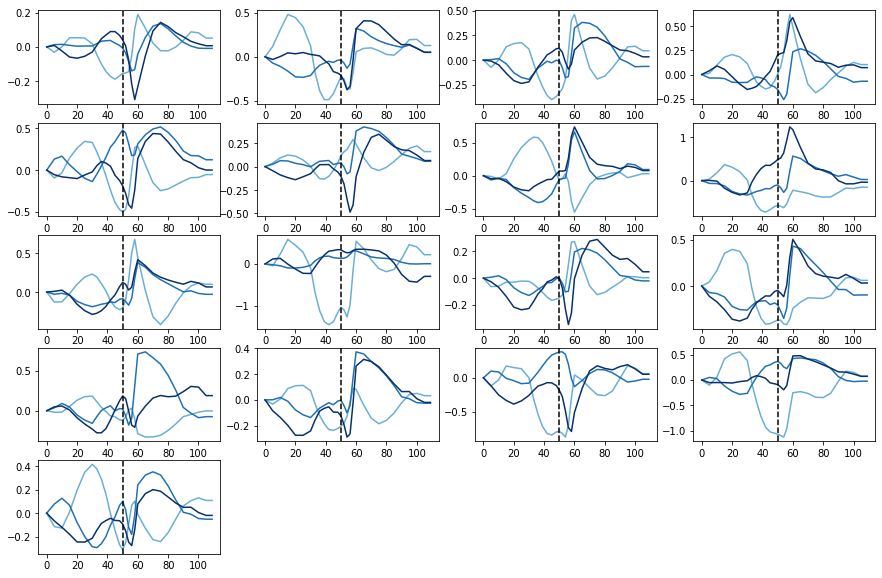

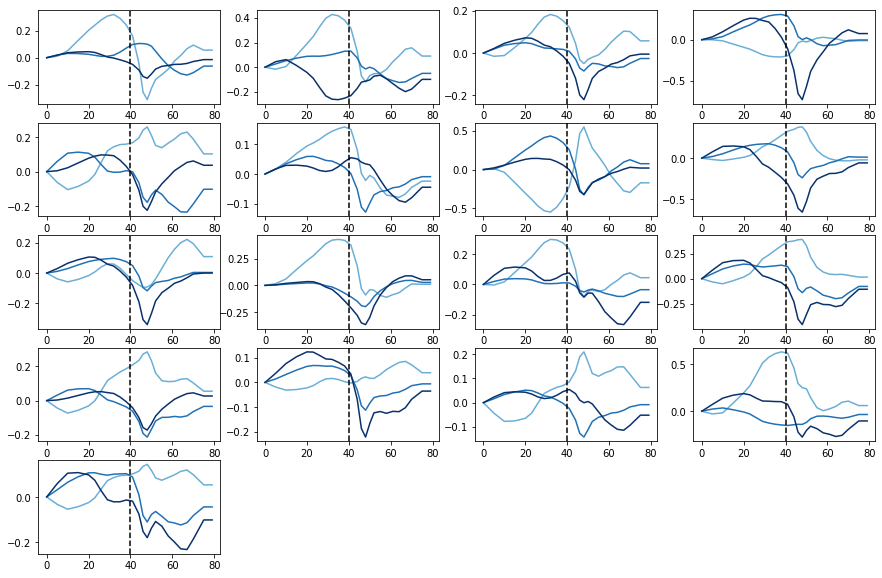

In [34]:
# plot kernels
ndn_mod = Mndn1.copy_model()
ffnet = 1
ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights
w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')
    
ffnet = 2
ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights
w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(Mback_shiftson, color='k', linestyle='--')

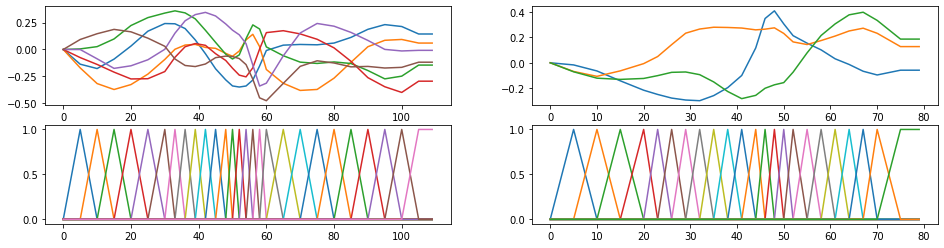

In [59]:
DU.subplot_setup(2,2)
ffnet=1
plt.subplot(2,2,1)
plt.plot(Mndn1.networks[ffnet].layers[0].filter_basis@Mndn1.networks[ffnet].layers[0].weights)
plt.subplot(2,2,3)
plt.plot(Mndn1.networks[ffnet].layers[0].filter_basis)
ffnet=2
plt.subplot(2,2,2)
plt.plot(Mndn1.networks[ffnet].layers[0].filter_basis@Mndn1.networks[ffnet].layers[0].weights)
plt.subplot(2,2,4)
plt.plot(Mndn1.networks[ffnet].layers[0].filter_basis)
plt.show()

#ks = DU.compute_spatiotemporal_filters(Mndn1, ffnet=ffnet)
#DU.subplot_setup(3,6)
#for nn in range(NC):
#    plt.subplot(3,6,nn+1)
#    plt.plot(ks[:,:,nn].T)
#plt.show()

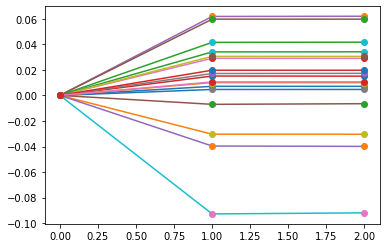

In [35]:
LLmat = np.array([LLx0, LLx1, LLx2])
plt.plot(LLmat-LLmat[0,:])
plt.plot(LLmat-LLmat[0,:],'o')
plt.show()

## Multiplicative model applied to separate stimulus term

In [18]:
# saccade modulation model is NOT shared
num_sactkerns = 6
num_Msactkerns = 3

stim_par = deepcopy(glm_par)  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[1.0], 'd2x':[None, None]})

# Second copy of stim par: network 2

## ffnet 3
Msac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_Monlags],
    xstim_n=[2],
    layer_sizes=[num_Msactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[1.0], 'd2x':[None, None]})

# ffnet 4
stim_comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[2,3], layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,4], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
Mndn2 = NDN.NDN([stim_par, sac_on_par, stim_par, Msac_on_par, stim_comb_par, comb_par], noise_dist='poisson')
Mndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )
Mndn2.networks[3].layers[0].init_temporal_basis( xs=tspacingM )

# stimulus is the same
Mndn2.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
Mndn2.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
Mndn2.networks[2].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
Mndn2.networks[2].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)

# add network has 0 bias and weights 1
Mndn2.networks[-1].layers[0].weights[:,:] = 1.0

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E6/I0] N
1: normal (lin):  	[E17/I0] 
Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E17/I0] 
0: mult (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 106 to 110.
  Temporal layer: updating number of weights in temporal layer from 110 to 27.
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 23.


In [20]:
# Train additive saccade model first
v2f0 = Mndn2.fit_variables(layers_to_skip=[[0,1], [], [0,1], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = Mndn2.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training M-2 saccade model")
LLx3 = Mndn2.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx3))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.861542
  Number of iterations: 3
  Number of functions evaluations: 25
Done training M-2 saccade model
0.320541 0.31874123


In [21]:
# Instead, train everything at once Or do this after)
v2f = Mndn2.fit_variables(layers_to_skip=[[0], [], [0], [], [0], [0]], fit_biases=False)
v2f[-1][-1]['biases']=True

_ = Mndn2.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training M-2 saccade model")
LLx3 = Mndn2.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx3))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.909096
  Number of iterations: 3085
  Number of functions evaluations: 3235
Done training M-2 saccade model
0.320541 0.2208718


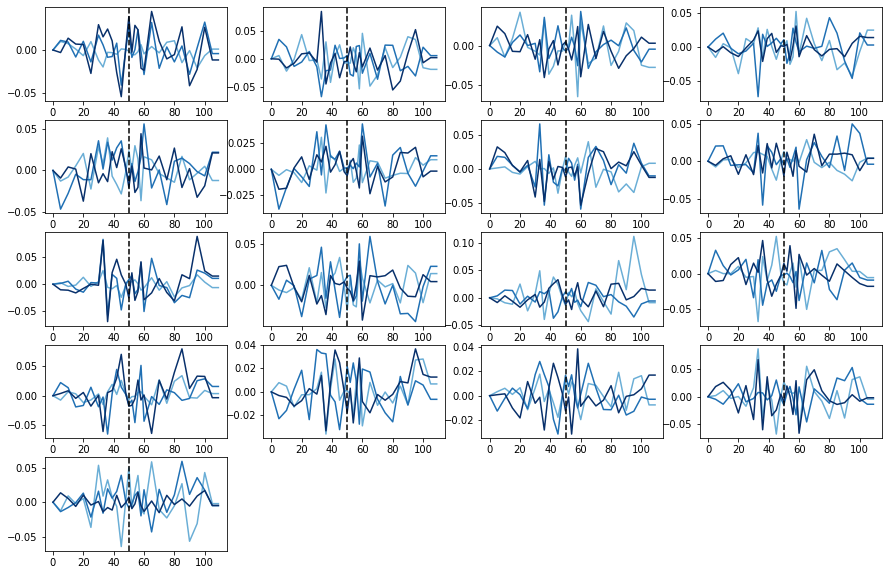

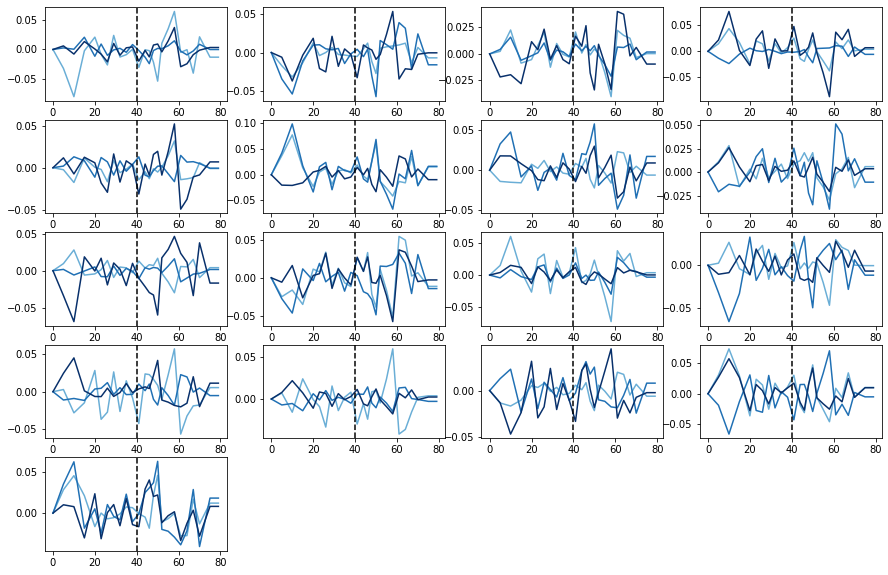

In [69]:
# plot kernels -- messy: try shared terms instead
ndn_mod = Mndn1.copy_model()
ffnet = 1
ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights
w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')
    
ffnet = 3
ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights
w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(Mback_shiftson, color='k', linestyle='--')

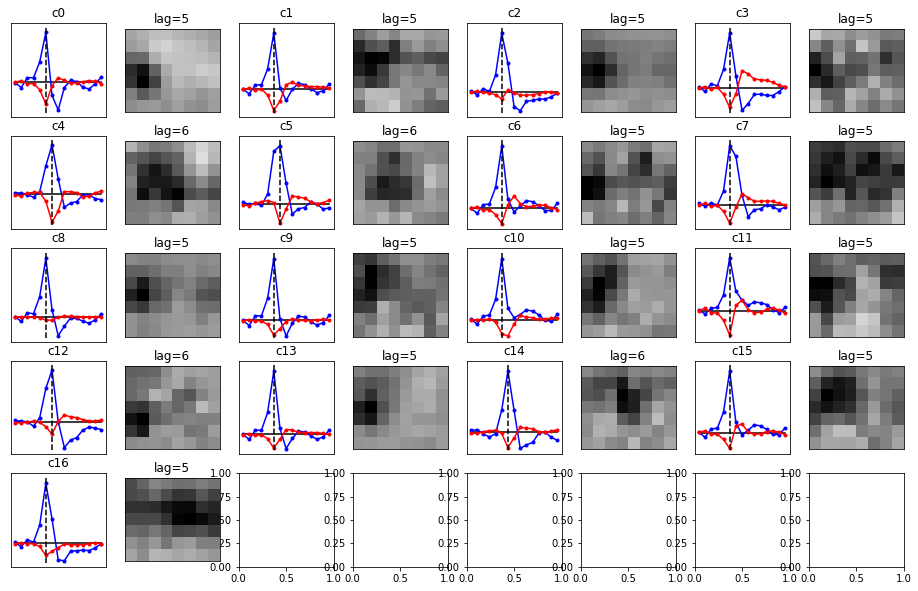

In [36]:
DU.plot_3dfilters(Mndn2)

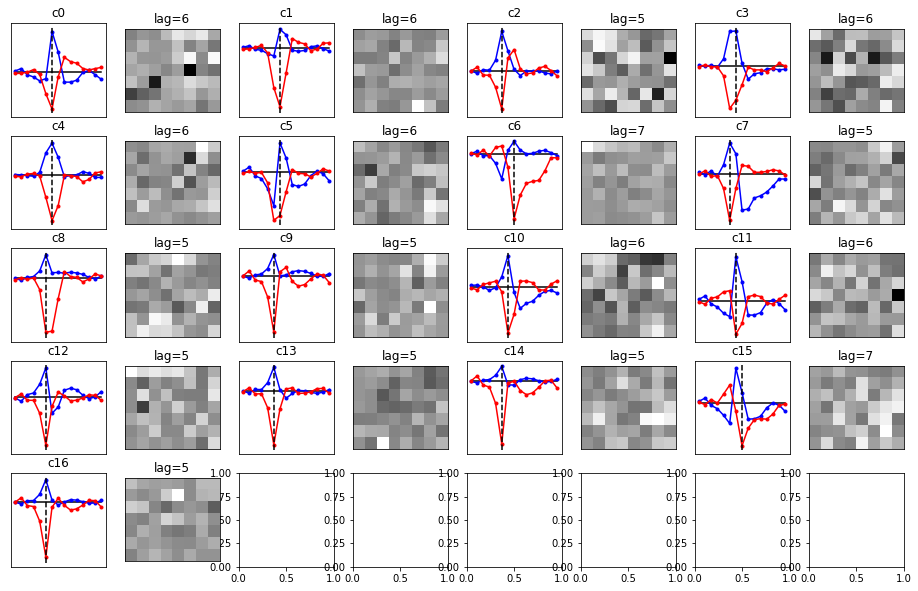

In [37]:
DU.plot_3dfilters(Mndn2, ffnet=2)

#### Argument for shared model (of at least multiplicative modulations....)

## Shared multiplicative model

In [46]:
num_sactkerns = 6
num_Msactkerns = 3
num_Msubunits = 4

# ffnet 0
stim_par = deepcopy(glm_par)  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

# ffnet 1
sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[1.0], 'd2x':[None, None]})

# ffnet 2 Second copy of stim par: network 2
stim_par_sub = deepcopy(glm_par)
stim_par_sub['layer_sizes'][1] = num_Msubunits

## ffnet 3
Msac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_Monlags],
    xstim_n=[2],
    layer_sizes=[num_Msactkerns, num_Msubunits], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[1.0], 'd2x':[None, None]})

# ffnet 4
mult_comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[2,3], layer_sizes=[num_Msubunits, NC],
    layer_types=['mult', 'normal'], normalization=[0,0], act_funcs=['lin', 'lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,4], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ShMndn0 = NDN.NDN([stim_par, sac_on_par, stim_par_sub, Msac_on_par, mult_comb_par, comb_par], 
                  noise_dist='poisson')
ShMndn0.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ShMndn0.networks[3].layers[0].init_temporal_basis( xs=tspacingM )

# stimulus is the same
ShMndn0.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ShMndn0.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
ShMndn0.networks[2].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ShMndn0.networks[2].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights[:,range(num_Msubunits)])

# add network has 0 bias and weights 1
Mndn2.networks[-1].layers[0].weights[:,:] = 1.0

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E6/I0] N
1: normal (lin):  	[E17/I0] 
Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E4/I0] 
0: mult (lin):  	[E4/I0] 
1: normal (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 106 to 110.
  Temporal layer: updating number of weights in temporal layer from 110 to 27.
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 23.


In [47]:
# Train everything but first stim term first
v2f = ShMndn0.fit_variables(layers_to_skip=[[0,1], [], [0], [], [0], [0]], fit_biases=False)
v2f[-1][-1]['biases']=True

_ = ShMndn0.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training M-2 saccade model")
LLx4 = ShMndn0.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx4))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.195862
  Number of iterations: 946
  Number of functions evaluations: 999
Done training M-2 saccade model
0.320541 0.28371435


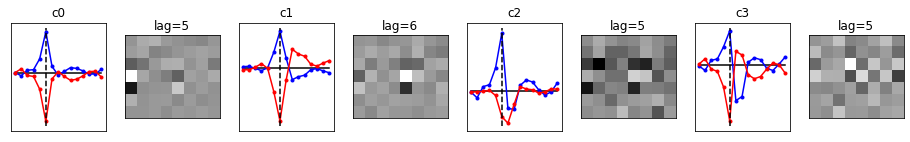

In [51]:
DU.plot_3dfilters(ShMndn0, ffnet=2)

In [52]:
_ = ShMndn0.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f, learning_alg='adam', opt_params=adam_params)


Epoch 0000:  avg train cost =     4.2918,  avg test cost =     4.6584,  reg penalty =     0.0367
Epoch 0029:  avg train cost =     4.2852,  avg test cost =     4.6694,  reg penalty =     0.0368
Epoch 0059:  avg train cost =     4.2846,  avg test cost =     4.6698,  reg penalty =     0.0369
Epoch 0089:  avg train cost =     4.2834,  avg test cost =     4.6736,  reg penalty =     0.0370

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 101,  end cost: 80.059744
     ---> best epoch: 1,  best cost: 79.802472



In [ ]:
# still overfit. but this could be refined....

In [53]:
LLx4 = ShMndn0.eval_models(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, 
                         data_indxs=Xi, nulladjusted=True)
print(np.mean(LLx0), np.mean(LLx4))

0.320541 0.25905985


## SCRATCH

In [13]:
predA = ndn1.generate_prediction(input_data=[stim, sacOnAmpshift], data_indxs=Xi)
predM = Mndn1.generate_prediction(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], data_indxs=Xi)
plt.plot(predA[range(100),1])
plt.plot(predM[range(100),1],'r--')
plt.show()

NameError: name 'ndn1' is not defined

In [20]:
Mndn1.networks[3].layers[0].weights[:] 

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [21]:
Mndn1.networks[3].layers[0].biases

array([[1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08,
        1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08, 1.e-08,
        1.e-08]], dtype=float32)

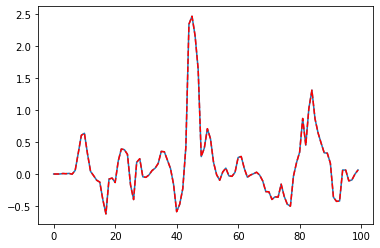

In [16]:
plt.plot(test2[range(100),1])
plt.plot(test20[range(100),1],'r--')
plt.show()

In [31]:
Mndn1.networks[3].layers[0].biases[:] = 0

In [32]:

# Refit all variables
v2f = Mndn1.fit_variables(layers_to_skip=[[0], [], [0], [0], [0]], fit_biases=False)
v2f[-1][-1]['biases']=True

_ = Mndn1.train(input_data=[stim, sacOnAmpshift, MsacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f, learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training saccade model")


unconstrained <tf.Variable 'network_3/mult_layer_0/weights_init/weights_var:0' shape=(1, 17) dtype=float32_ref>
Tensor("network_3/mult_layer_0/Mul:0", shape=(?, 17), dtype=float32)
pre Tensor("network_3/mult_layer_0/Slice_1:0", shape=(?, 17), dtype=float32)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.309891
  Number of iterations: 1
  Number of functions evaluations: 17
Done training saccade model


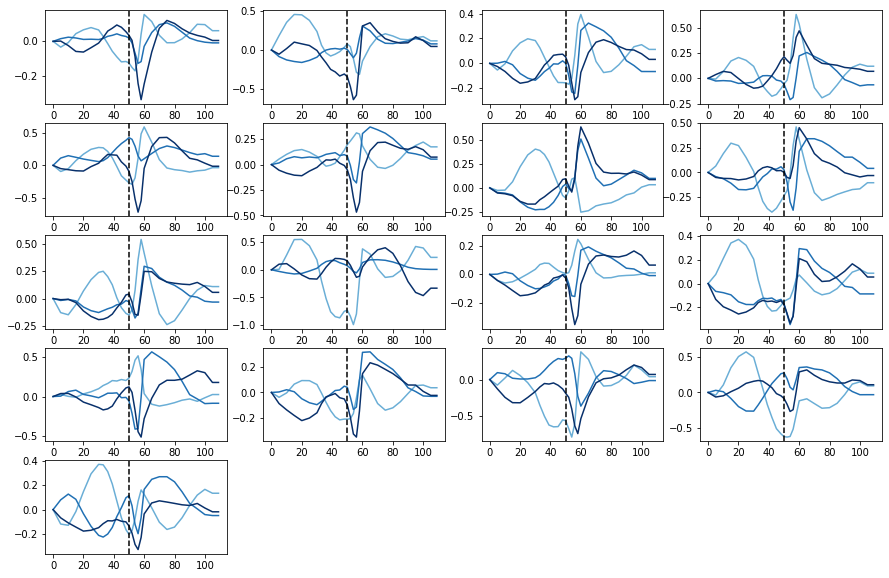

In [17]:
# plot kernels
ndn_mod = Mndn1.copy_model()
ffnet = 1
# filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet) # not working??

ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)

w = ks_flat #@ndn_mod.networks[ffnet].layers[-1].weights

w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')

### Shared additive model

In [177]:
# saccade modulation model is shared
num_sacsubs = 4
num_sactkerns = 3

stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal', 'normal'],
    act_funcs=['lin', 'lin', 'lin'],
    normalization=[1, 1, 0],
    reg_list={'orth':[0.01], 'd2t':[0.05], 'd2x':[None, None]})


comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn2 = NDN.NDN([stim_par, sac_on_par, comb_par], noise_dist='poisson')
ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )

# stimulus is the same
ndn2.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ndn2.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
ndn2.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add network has 0 bias and weights 1
#ndn2.networks[2].layers[0].weights /= ndn2.networks[2].layers[0].weights
ndn2.networks[2].layers[0].weights[:,:] = 1.0

# Train
v2f0 = ndn2.fit_variables(layers_to_skip=[[0,1], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

# Refit all variables
v2f0 = ndn2.fit_variables(layers_to_skip=[[0], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E4/I0] N
2: normal (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 96 to 100.
  Temporal layer: updating number of weights in temporal layer from 100 to 25.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.192467
  Number of iterations: 227
  Number of functions evaluations: 258
Done training additive saccade model
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.192451
  Number of iterations: 3
  Number of functions evaluations: 37
Done training additive saccade model


Text(0.5, 1.0, 'Sac Onset Basis')

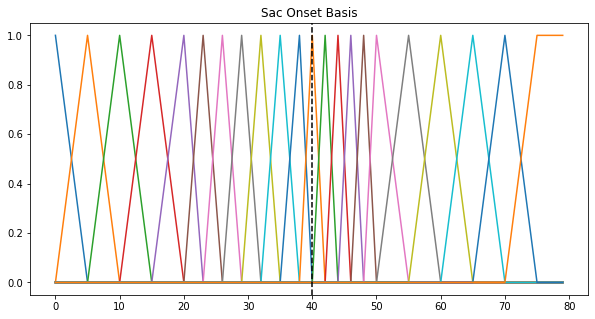

In [104]:
plt.figure(figsize=(10,5))
f = plt.plot(ndn2.networks[1].layers[0].filter_basis)
plt.axvline(back_shiftson, color='k', linestyle='--')
plt.title("Sac Onset Basis")

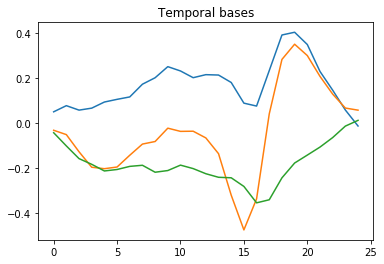

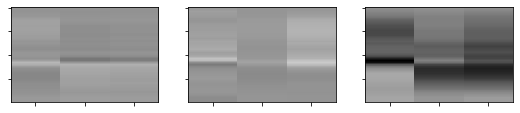

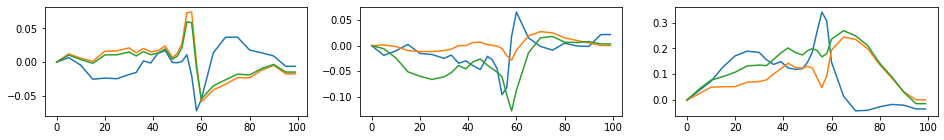

In [167]:
DU.plot_filters(ndn2, ffnet=1)
ks = DU.compute_spatiotemporal_filters(ndn2, ffnet=1)
DU.subplot_setup(1,3)
for nn in range(3):
    plt.subplot(1,3,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()

0.3188895 0.3477287


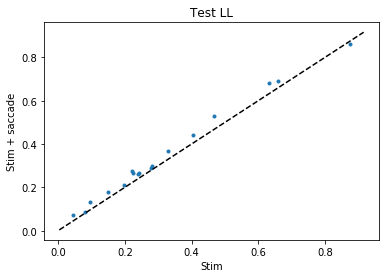

In [168]:
glm.time_spread=ndn2.time_spread
LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx1 = ndn2.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)

plt.plot(LLx0, LLx1, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim')
plt.ylabel('Stim + saccade')

Rpred0 = glm.generate_prediction(input_data=[stim])
Rpred1 = ndn2.generate_prediction(input_data=[stim, sacOnAmpshift])
print(np.mean(LLx0), np.mean(LLx1))

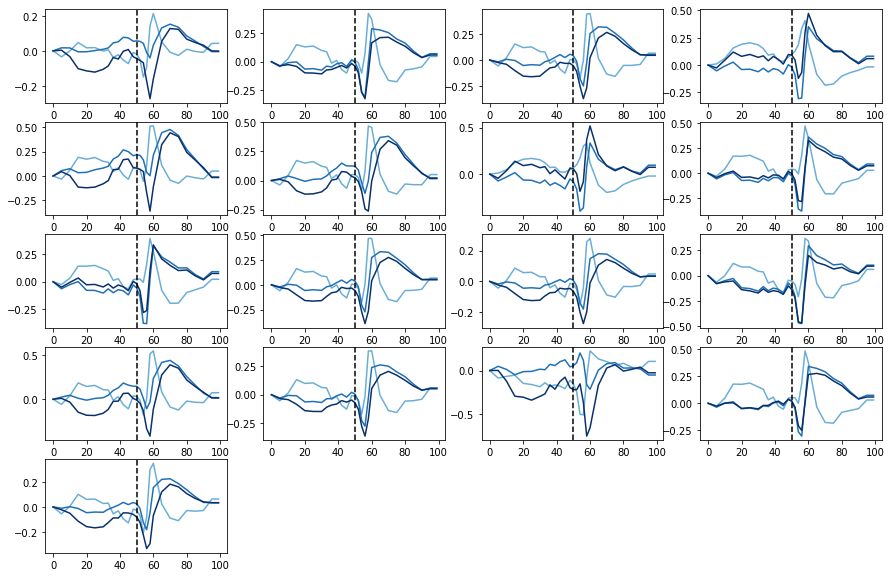

In [169]:
# plot kernels
ndn_mod = ndn2.copy_model()
ffnet = 1
# filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet) # not working??

ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)

w = ks_flat@ndn_mod.networks[ffnet].layers[2].weights

w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')

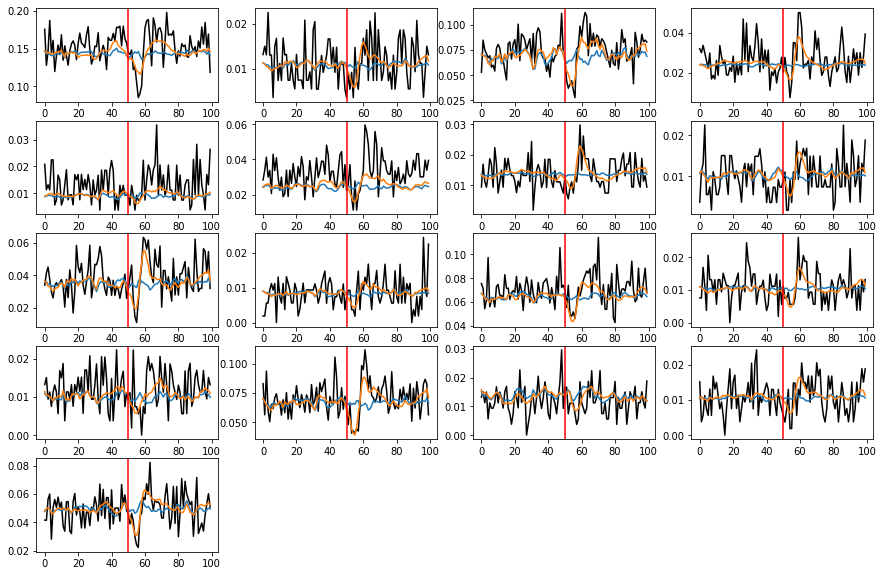

In [170]:
# plot the saccade-triggered firing rate 
nlags = 100

# use sacAmpshift to see if there's modulation / size selectivity
Xsacon = NDNutils.create_time_embedding( saconshift, [nlags, 1, 1], tent_spacing=1)

NC = Robs.shape[1]
cm = plt.cm

sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))

r2glm = []
r2sac = []
for cc in range(NC):
    
    rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon # Data
    rmult0 = np.expand_dims(Rpred0[:,cc], axis=1)*Xsacon # GLM
    rmult1 = np.expand_dims(Rpred1[:,cc], axis=1)*Xsacon # GLM + Saccade Modulation
    
    sactaData = np.sum(rmult[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta0 = np.sum(rmult0[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta1 = np.sum(rmult1[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)

    plt.subplot(sx,sy,cc+1)
    plt.plot(sactaData, color='k')
    plt.plot(sacta0)
    plt.plot(sacta1)
    
    sactaData = np.expand_dims(sactaData, axis=1)
    sacta0 = np.expand_dims(sacta0, axis=1)
    sacta1 = np.expand_dims(sacta1, axis=1)
    
    r2glm.append(U.r_squared(sactaData, sacta0))
    r2sac.append(U.r_squared(sactaData, sacta1))

    plt.axvline(x=back_shiftson,color='r')

Text(0, 0.5, 'Stim + sac')

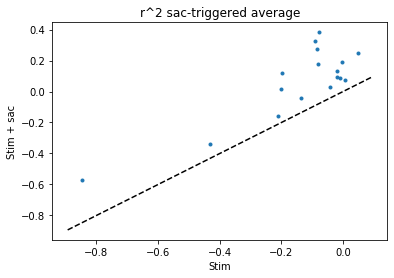

In [17]:
plt.plot(np.asarray(r2glm), np.asarray(r2sac), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('r^2 sac-triggered average')
plt.xlabel('Stim')
plt.ylabel('Stim + sac')

## Separate presaccadic and postsaccadic terms just based on sacc onset

In [11]:
# build saccade inputs
num_prelags = 60
num_postlags = 50

pre_params = 24
post_params = 20 

#saconshift = NDNutils.shift_mat_zpad(sacon,-back_shiftson,dim=0)
sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-num_prelags,dim=0)
print("%d nans found" %(np.sum(np.isnan(sacOnAmpshift))))

0 nans found


In [12]:
# saccade modulation model is NOT shared
num_sactkerns_pre = 5
num_sactkerns_post = 5

stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par1 = NDNutils.ffnetwork_params(  # following saccade
    input_dims=[1,nSacBasis,1],
    time_expand=[num_postlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns_post, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[0.1], 'd2x':[None, None]})

sac_on_par2 = NDNutils.ffnetwork_params(
    input_dims=[1,nSacBasis,1],
    time_expand=[num_prelags],
    xstim_n=[2],
    layer_sizes=[num_sactkerns_pre, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[0.1], 'd2t':[0.1], 'd2x':[None, None]})


comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ppndn1 = NDN.NDN([stim_par, sac_on_par1, sac_on_par2, comb_par], noise_dist='poisson')
ppndn1.networks[1].layers[0].init_temporal_basis( num_params=post_params, doubling_time=8, end_at_zero=True  )
ppndn1.networks[2].layers[0].init_temporal_basis( num_params=pre_params, doubling_time=8, end_at_zero=True  )
# flip second basis around
ppndn1.networks[2].layers[0].filter_basis = np.flip(ppndn1.networks[2].layers[0].filter_basis, axis=0)
# stimulus is the same
ppndn1.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ppndn1.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
#ppndn1.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add network has 0 bias and weights 1
#ppndn1.networks[3].layers[0].weights[:,:] = 1.0

# Train
v2f0 = ppndn1.fit_variables(layers_to_skip=[[0,1], [], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ppndn1.train(input_data=[stim, sacOnAmp, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

# Refit all variables
v2f0 = ppndn1.fit_variables(layers_to_skip=[[0], [], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ppndn1.train(input_data=[stim, sacOnAmp, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E5/I0] N
1: normal (lin):  	[E17/I0] 
Input dimensions: [1, 3, 1]
0: temporal (lin):  	[E5/I0] N
1: normal (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 37 to 50.
  Temporal layer: updating number of weights in temporal layer from 50 to 20.
  Temporal layer: must expand temporal basis from 53 to 60.
  Temporal layer: updating number of weights in temporal layer from 60 to 24.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.566292
  Number of iterations: 145
  Number of functions evaluations: 169
Done training additive saccade model
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.324402
  Number of iterations: 117
  Number of functions evaluations: 137
Done training additive saccade model


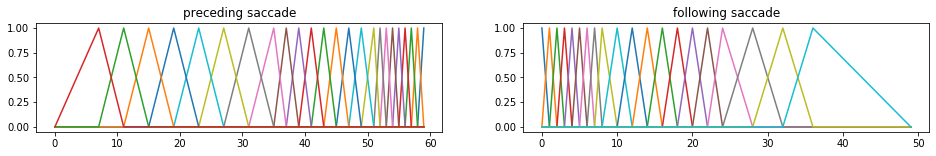

In [13]:
DU.subplot_setup(1,2)
plt.subplot(1,2,1)
plt.plot(ppndn1.networks[2].layers[0].filter_basis)
plt.title('preceding saccade')
plt.subplot(1,2,2)
plt.plot(ppndn1.networks[1].layers[0].filter_basis)
plt.title('following saccade')
plt.show()

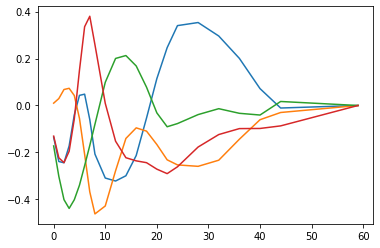

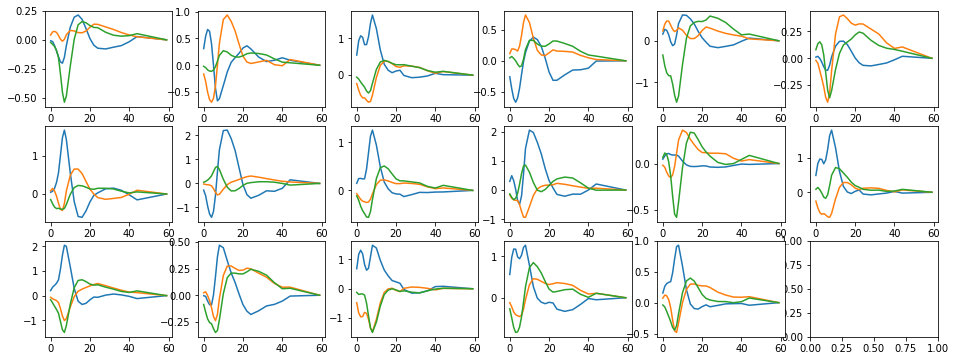

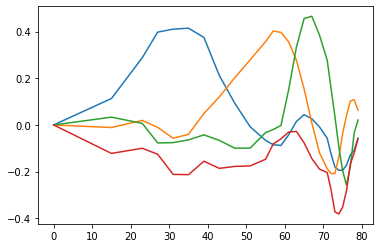

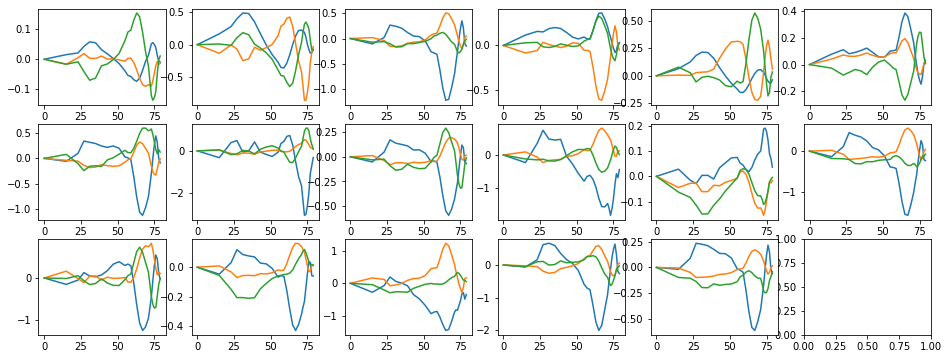

In [273]:
# Postsaccadic
plt.plot(ppndn1.networks[1].layers[0].filter_basis@ppndn1.networks[1].layers[0].weights)
plt.show()
ks = DU.compute_spatiotemporal_filters(ppndn1, ffnet=1)
DU.subplot_setup(3,6)
for nn in range(NC):
    plt.subplot(3,6,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()
plt.plot(ppndn1.networks[2].layers[0].filter_basis@ppndn1.networks[2].layers[0].weights)
plt.show()
ks = DU.compute_spatiotemporal_filters(ppndn1, ffnet=2)
DU.subplot_setup(3,6)
for nn in range(NC):
    plt.subplot(3,6,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()

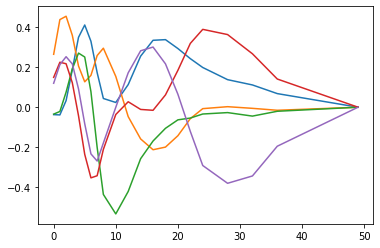

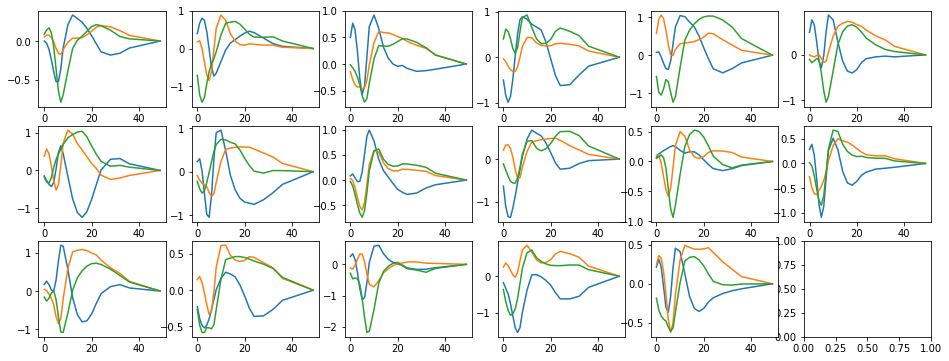

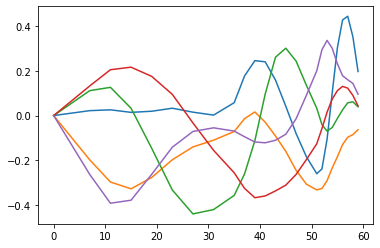

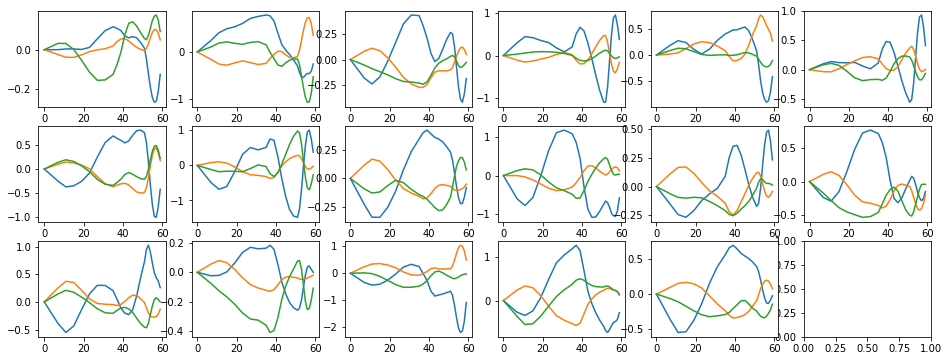

In [15]:
# Postsaccadic
plt.plot(ppndn1.networks[1].layers[0].filter_basis@ppndn1.networks[1].layers[0].weights)
plt.show()
ks = DU.compute_spatiotemporal_filters(ppndn1, ffnet=1)
DU.subplot_setup(3,6)
for nn in range(NC):
    plt.subplot(3,6,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()
plt.plot(ppndn1.networks[2].layers[0].filter_basis@ppndn1.networks[2].layers[0].weights)
plt.show()
ks = DU.compute_spatiotemporal_filters(ppndn1, ffnet=2)
DU.subplot_setup(3,6)
for nn in range(NC):
    plt.subplot(3,6,nn+1)
    plt.plot(ks[:,:,nn].T)
plt.show()

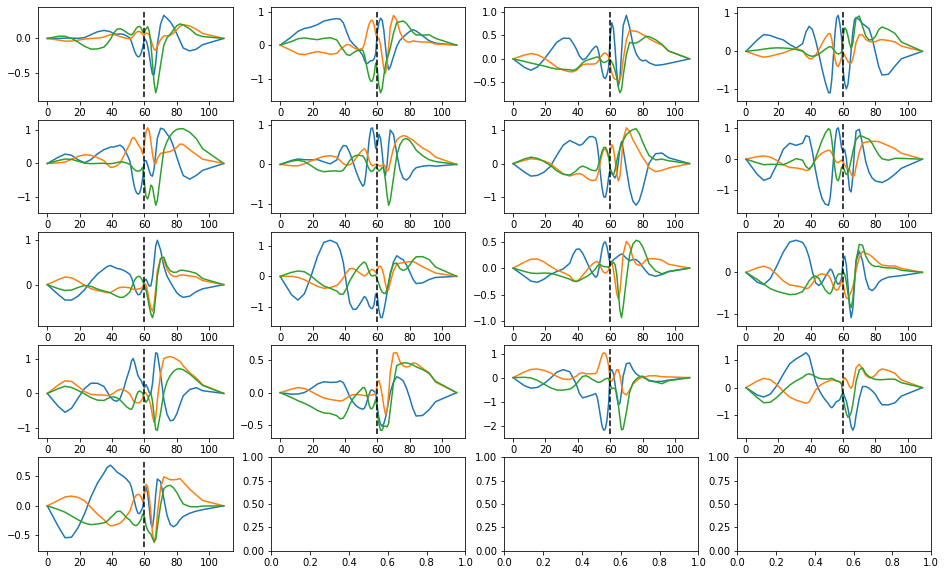

In [16]:
ks1 = DU.compute_spatiotemporal_filters(ppndn1, ffnet=1)
ks2 = DU.compute_spatiotemporal_filters(ppndn1, ffnet=2)
ks = np.concatenate( (ks2,ks1), axis=1)
DU.subplot_setup(5,4)
for nn in range(NC):
    plt.subplot(5,4,nn+1)
    plt.plot(ks[:,:,nn].T)
    plt.plot([num_prelags, num_prelags], plt.ylim(), 'k--')
plt.show()


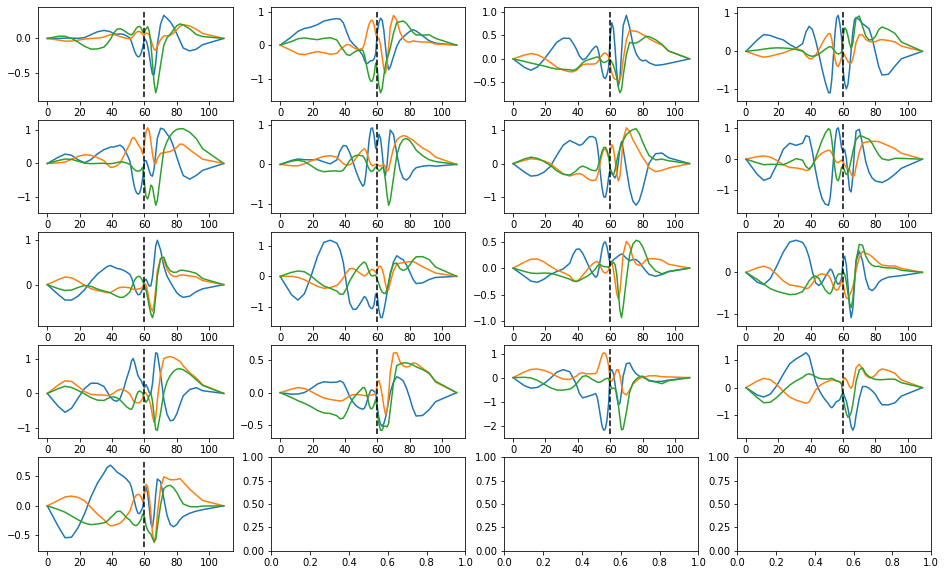

In [14]:
ks1 = DU.compute_spatiotemporal_filters(ppndn1, ffnet=1)
ks2 = DU.compute_spatiotemporal_filters(ppndn1, ffnet=2)
ks = np.concatenate( (ks2,ks1), axis=1)
DU.subplot_setup(5,4)
for nn in range(NC):
    plt.subplot(5,4,nn+1)
    plt.plot(ks[:,:,nn].T)
    plt.plot([num_prelags, num_prelags], plt.ylim(), 'k--')
plt.show()


### Try adding the saccade during parameter as a gain

In [18]:
# the model will have 6 FF networks
# 0: stimulus
# 1: saccade onset
# 2: saccade offset
# 3: saccade during
# 4: mult (0,3)
# 5: add (0,1,2,4)

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,nSacBasis],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal', 'normal'],
    act_funcs=['lin', 'lin', 'lin'],
    normalization=[1, 1, 0],
    reg_list={'orth':[None], 'd2t':[1e-1], 'l2':[None, 1e-5, None]})

mult_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,2], layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[1,3], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn3 = NDN.NDN([stim_par, sac_on_par, sac_on_par, mult_par, comb_par], ffnet_out=4, noise_dist='poisson')
ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacing )

# stimulus is the same
ndn3.networks[0].layers[0].weights = deepcopy(ndn2.networks[0].layers[0].weights)
ndn3.networks[0].layers[0].biases = deepcopy(ndn2.networks[0].layers[0].biases)
ndn3.networks[0].layers[1].weights = deepcopy(ndn2.networks[0].layers[1].weights)
ndn3.networks[0].layers[1].biases = deepcopy(ndn2.networks[0].layers[1].biases)

# add network weights 1 and bias copied from ndn2
ndn3.networks[4].layers[0].weights /= ndn3.networks[4].layers[0].weights
ndn3.networks[-1].layers[-1].biases = deepcopy(ndn2.networks[-1].layers[-1].biases)

# mult network has 0 bias and weights 1
ndn3.networks[3].layers[0].weights /= ndn3.networks[3].layers[0].weights


# ndn3.networks[2].layers[0].weights *= 0 #deepcopy(ndn2.networks[1].layers[0].weights)
# ndn3.networks[2].layers[1].weights *= 0 #deepcopy(ndn2.networks[1].layers[1].weights)
ndn3.networks[2].layers[2].weights = deepcopy(ndn2.networks[1].layers[2].weights)

Input dimensions: [1, 1, 3]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E3/I0] N
2: normal (lin):  	[E17/I0] 
0: mult (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 22.
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 22.


In [19]:
# ONLY run this cell if you want to see what happens if the additive kernels are out of the picture

# take additive kernel out of the picture and train multiplicative kernel
ndn3.networks[1].layers[0].weights *= 0 #deepcopy(ndn2.networks[1].layers[0].weights)
ndn3.networks[1].layers[1].weights *= 0 #deepcopy(ndn2.networks[1].layers[1].weights)

# Train with adam optimizer
v2f0 = ndn3.fit_variables(layers_to_skip=[[0], [0,1,2], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =    52.5087,  avg test cost =    56.0633,  reg penalty =     0.0806
Epoch 0029:  avg train cost =     5.0994,  avg test cost =     5.6005,  reg penalty =     0.0613
Epoch 0059:  avg train cost =     4.4038,  avg test cost =     4.7399,  reg penalty =     0.0480
Epoch 0089:  avg train cost =     4.3574,  avg test cost =     4.6713,  reg penalty =     0.0321
Epoch 0119:  avg train cost =     4.3426,  avg test cost =     4.6557,  reg penalty =     0.0240
Epoch 0149:  avg train cost =     4.3395,  avg test cost =     4.6452,  reg penalty =     0.0206
Epoch 0179:  avg train cost =     4.3344,  avg test cost =     4.6445,  reg penalty =     0.0190
Epoch 0209:  avg train cost =     4.3399,  avg test cost =     4.6588,  reg penalty =     0.0182
Epoch 0239:  avg train cost =     4.3280,  avg test cost =     4.6389,  reg penalty =     0.0179
Epoch 0269:  avg train cost =     4.3295,  avg test cost =     4.6468,  reg penalty =     0.0178

*** early stop criteria met..

In [20]:
# saccade onset initialized with ndn2
ndn3.networks[1].layers[0].weights = deepcopy(ndn2.networks[1].layers[0].weights)
ndn3.networks[1].layers[1].weights = deepcopy(ndn2.networks[1].layers[1].weights)
ndn3.networks[1].layers[2].weights = deepcopy(ndn2.networks[1].layers[2].weights)

# Train with adam optimizer
v2f0 = ndn3.fit_variables(layers_to_skip=[[0,1], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =     4.3212,  avg test cost =     4.6413,  reg penalty =     0.0189
Epoch 0029:  avg train cost =     4.3139,  avg test cost =     4.6362,  reg penalty =     0.0185
Epoch 0059:  avg train cost =     4.3155,  avg test cost =     4.6412,  reg penalty =     0.0183
Epoch 0089:  avg train cost =     4.3170,  avg test cost =     4.6356,  reg penalty =     0.0181

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 101,  end cost: 79.038305
     ---> best epoch: 22,  best cost: 78.838721

Done training gain saccade model


In [21]:
v2f0 = ndn3.fit_variables(layers_to_skip=[[0], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =     4.3125,  avg test cost =     4.6358,  reg penalty =     0.0180
Epoch 0029:  avg train cost =     4.3120,  avg test cost =     4.6340,  reg penalty =     0.0178
Epoch 0059:  avg train cost =     4.3124,  avg test cost =     4.6382,  reg penalty =     0.0176
Epoch 0089:  avg train cost =     4.3147,  avg test cost =     4.6332,  reg penalty =     0.0175

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 101,  end cost: 79.039442
     ---> best epoch: 22,  best cost: 78.857912

Done training gain saccade model


Text(0, 0.5, 'Stim + saccade on/off/dur')

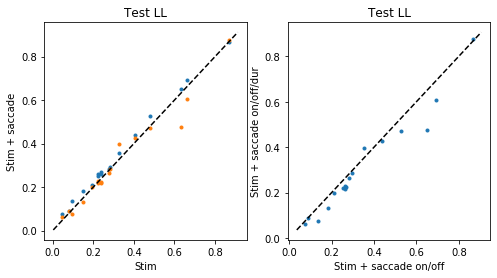

In [22]:
glm.time_spread=ndn3.time_spread
ndn2.time_spread = ndn3.time_spread

LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx1 = ndn2.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx2 = ndn3.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(LLx0, LLx1, '.')
plt.plot(LLx0, LLx2, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim')
plt.ylabel('Stim + saccade')

plt.subplot(122)
plt.plot(LLx1, LLx2, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim + saccade on/off')
plt.ylabel('Stim + saccade on/off/dur')